## Imports

In [1]:
import os
os.environ['R_HOME'] = '/opt/modules/i12g/anaconda/envs/kipoi-veff-analysis/lib/R'

In [2]:
import polars as pl
from pathlib import Path
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import plotnine as pn
# rpy2 dependencies
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.rinterface_lib.embedded import RRuntimeError
import pandas as pd
import statsmodels.api as sm
from scipy.ndimage import gaussian_filter

In [3]:
rbase = importr('base')
rdirichlet_reg = importr('DirichletReg')

## Input

In [4]:
gtex_annotation_path = Path('/s/project/gtex_genetic_diagnosis/v8/sample_annotation.tsv')
gtf_path = Path('/s/project/rep/processed/training_results_v15/gtex_v8_old_dna/gtf_transcripts.parquet')
gtex_transcript_tpm_path = Path('/s/project/rep/processed/training_results_v15/general/gtex_transcript_tpms.zarr/')
genes_path = Path('/data/nasif12/home_if12/tsi/projects/kipoi_veff_analysis/assets/genes.txt')
output_path = Path('/data/nasif12/home_if12/tsi/projects/kipoi_veff_analysis/output/sex_isoforms')

## Load data

In [5]:
def load_transcript_data(gtf_path):
    transcript_ldf = pl.scan_parquet(gtf_path). \
        filter((pl.col('Feature') == 'transcript') & (pl.col('gene_type') == 'protein_coding')). \
        with_columns(gene_id=pl.col('gene_id').str.replace(r"([^\.]+)\..+$", "${1}"),
                     transcript_id=pl.col('transcript_id').str.replace(r"([^\.]+)\..+$", "${1}")). \
        select(['gene_id', 'transcript_id', 'Chromosome']). \
        unique(). \
        rename({'gene_id': 'gene', 'transcript_id': 'transcript', 'Chromosome': 'chrom'}). \
        filter(~pl.col('chrom').is_in(['chrX', 'chrY'])). \
        select(['gene', 'transcript', 'chrom'])
    transcript_df = transcript_ldf.collect().to_pandas().set_index('transcript')
    transcript_xrds = xr.Dataset.from_dataframe(transcript_df).set_coords(("gene", "chrom"))
    genes = transcript_xrds.to_pandas().reset_index().groupby('gene').count().query('transcript > 1').index
    return transcript_xrds.sel(transcript=transcript_xrds['gene'].isin(genes))


def load_individual_data(gtex_annotation_path):
    gtex_individual_df = pl.read_csv(gtex_annotation_path, separator='\t'). \
        select(['INDIVIDUAL_ID', 'SEX']). \
        rename({'INDIVIDUAL_ID': 'individual', 'SEX': 'sex'}). \
        unique()
    return gtex_individual_df.to_pandas().set_index('individual')


def load_expression_data(gtex_transcript_tpm_path, gtex_individual_df):
    expression_xrds = xr.open_zarr(gtex_transcript_tpm_path)
    individuals = ['-'.join(x.split('-')[0:2]) for x in expression_xrds['sample'].data]
    expression_xrds = expression_xrds.assign_coords(dict(individual=('sample', individuals)))
    del expression_xrds['gene']
    expression_xrds = expression_xrds.sel(transcript=~expression_xrds.transcript.str.endswith('_PAR_Y'))
    transcripts = [x.split('.')[0] for x in expression_xrds.transcript.values]
    expression_xrds = expression_xrds.assign_coords(dict(transcript=transcripts))
    individuals = np.intersect1d(expression_xrds['individual'].values, gtex_individual_df.index.values)
    expression_xrds = expression_xrds.sel(sample=expression_xrds['individual'].isin(individuals))
    return expression_xrds.assign_coords(
        sex=('sample', gtex_individual_df.loc[expression_xrds['individual'].data]['sex'].values)
    )


def balanced_sample(data, min_samples_per_sex_tissue=100, seed=42):
    """
    Balance the samples by selecting the same number of samples for each sex in each tissue.
    Every individual should only have one sample per tissue.

    :param data:
    :param seed:
    :return:
    """

    result = []

    # global balance of individuals
    # Ensure one sample per individual per tissue
    data_unique = data.drop_duplicates(subset=['individual', 'tissue'])

    # Split by sex globally
    males_global = data_unique[data_unique['sex'] == 'Male']
    females_global = data_unique[data_unique['sex'] == 'Female']
    
    # Find the minimum count of unique individuals between sexes globally
    min_count_global = min(len(males_global['individual'].unique()), len(females_global['individual'].unique()))

    # Sample globally balanced individuals
    sampled_males = males_global.drop_duplicates(subset='individual').sample(n=min_count_global, random_state=42)
    sampled_females = females_global.drop_duplicates(subset='individual').sample(n=min_count_global, random_state=42)
    
    #Keep all tissues and balance sexes per tissue
    balanced_individuals = pd.concat([sampled_males['individual'], sampled_females['individual']]).unique()
    for tissue, group in data_unique.groupby('tissue'):
        # Get individuals in this tissue and in the balanced individuals set
        tissue_group = group[group['individual'].isin(balanced_individuals)]
        
        # Separate males and females in the tissue
        males_in_tissue = tissue_group[tissue_group['sex'] == 'Male']
        females_in_tissue = tissue_group[tissue_group['sex'] == 'Female']
        
        # Find the minimum number between males and females for balance in the tissue
        min_count_tissue = min(len(males_in_tissue), len(females_in_tissue))
        if min_count_tissue < min_samples_per_sex_tissue:
            continue
        
        # Sample balanced individuals for this tissue
        sampled_males_tissue = males_in_tissue.sample(n=min_count_tissue, random_state=seed)
        sampled_females_tissue = females_in_tissue.sample(n=min_count_tissue, random_state=seed)
        
        # Append the balanced samples for the tissue
        result.append(pd.concat([sampled_males_tissue, sampled_females_tissue]))

    # Concatenate the results for all tissues
    return pd.concat(result)

In [14]:
transcript_xrds = load_transcript_data(gtf_path)
gtex_individual_df = load_individual_data(gtex_annotation_path)
expression_xrds = load_expression_data(gtex_transcript_tpm_path, gtex_individual_df)

In [15]:
transcript_xrds

<xarray.Dataset> Size: 4MB
Dimensions:     (transcript: 145888)
Coordinates:
    gene        (transcript) object 1MB 'ENSG00000146143' ... 'ENSG00000109956'
    chrom       (transcript) object 1MB 'chr6' 'chr22' ... 'chr14' 'chr11'
  * transcript  (transcript) object 1MB 'ENST00000419977' ... 'ENST00000392580'
Data variables:
    *empty*

In [16]:
expression_xrds

<xarray.Dataset> Size: 14GB
Dimensions:     (sample: 17380, transcript: 199166)
Coordinates:
  * sample      (sample) object 139kB 'GTEX-1117F-0226-SM-5GZZ7' ... 'GTEX-ZZ...
    subtissue   (sample) object 139kB ...
    tissue      (sample) object 139kB ...
    individual  (sample) <U10 695kB 'GTEX-1117F' 'GTEX-1117F' ... 'GTEX-ZZPU'
  * transcript  (transcript) <U15 12MB 'ENST00000373020' ... 'ENST00000638628'
    sex         (sample) object 139kB 'Female' 'Female' ... 'Female' 'Female'
Data variables:
    tpm         (transcript, sample) float32 14GB ...

In [17]:
# filter samples
# only keep tissues found in both sexes
tissue_sex_count = expression_xrds[['tissue', 'individual', 'sex']].to_pandas().reset_index()[
    ['tissue', 'sex']].drop_duplicates().groupby('tissue').count()
unisex_tissues = tissue_sex_count.query('sex == 2').index.values
expression_xrds = expression_xrds.sel(sample=expression_xrds['tissue'].isin(unisex_tissues))
# balance the samples
balanced_df = balanced_sample(expression_xrds[['sample']].to_pandas())
expression_xrds = expression_xrds.sel(sample=balanced_df.index.values)
expression_xrds

<xarray.Dataset> Size: 5GB
Dimensions:     (sample: 5986, transcript: 199166)
Coordinates:
  * sample      (sample) object 48kB 'GTEX-132QS-0826-SM-5K7WV' ... 'GTEX-1H1...
    subtissue   (sample) object 48kB 'Adipose - Visceral (Omentum)' ... 'Thyr...
    tissue      (sample) object 48kB 'Adipose Tissue' ... 'Thyroid'
    individual  (sample) <U10 239kB 'GTEX-132QS' 'GTEX-1EN7A' ... 'GTEX-1H1CY'
  * transcript  (transcript) <U15 12MB 'ENST00000373020' ... 'ENST00000638628'
    sex         (sample) object 48kB 'Male' 'Male' 'Male' ... 'Female' 'Female'
Data variables:
    tpm         (transcript, sample) float32 5GB ...

In [18]:
# merge genome annotation and expression data
final_xrds = xr.merge([expression_xrds, transcript_xrds], join='inner')
# genes = np.unique(final_xrds['gene'].data)
# np.savetxt('../../../assets/genes.txt', genes, fmt='%s', delimiter='\n')
final_xrds

<xarray.Dataset> Size: 3GB
Dimensions:     (sample: 5986, transcript: 137988)
Coordinates:
  * sample      (sample) object 48kB 'GTEX-132QS-0826-SM-5K7WV' ... 'GTEX-1H1...
  * transcript  (transcript) object 1MB 'ENST00000371582' ... 'ENST00000622217'
    subtissue   (sample) object 48kB 'Adipose - Visceral (Omentum)' ... 'Thyr...
    tissue      (sample) object 48kB 'Adipose Tissue' ... 'Thyroid'
    individual  (sample) <U10 239kB 'GTEX-132QS' 'GTEX-1EN7A' ... 'GTEX-1H1CY'
    sex         (sample) object 48kB 'Male' 'Male' 'Male' ... 'Female' 'Female'
    gene        (transcript) object 1MB 'ENSG00000000419' ... 'ENSG00000243811'
    chrom       (transcript) object 1MB 'chr20' 'chr20' ... 'chr5' 'chr22'
Data variables:
    tpm         (transcript, sample) float32 3GB ...

In [19]:
gene_index = 1
genes = np.loadtxt(genes_path, dtype=str)
gene = genes[gene_index]
gene = 'ENSG00000076662'

In [20]:
gene_selector = final_xrds['gene'] == gene
final_xrds = final_xrds.sel(transcript=gene_selector)
final_xrds

<xarray.Dataset> Size: 671kB
Dimensions:     (sample: 5986, transcript: 10)
Coordinates:
  * sample      (sample) object 48kB 'GTEX-132QS-0826-SM-5K7WV' ... 'GTEX-1H1...
  * transcript  (transcript) object 80B 'ENST00000160262' ... 'ENST00000592945'
    subtissue   (sample) object 48kB 'Adipose - Visceral (Omentum)' ... 'Thyr...
    tissue      (sample) object 48kB 'Adipose Tissue' ... 'Thyroid'
    individual  (sample) <U10 239kB 'GTEX-132QS' 'GTEX-1EN7A' ... 'GTEX-1H1CY'
    sex         (sample) object 48kB 'Male' 'Male' 'Male' ... 'Female' 'Female'
    gene        (transcript) object 80B 'ENSG00000076662' ... 'ENSG00000076662'
    chrom       (transcript) object 80B 'chr19' 'chr19' ... 'chr19' 'chr19'
Data variables:
    tpm         (transcript, sample) float32 239kB ...

In [21]:
zero_read_count_percentage = (final_xrds['tpm'] < 1).mean(axis=1)
final_xrds = final_xrds.sel(transcript=zero_read_count_percentage < 0.90)

In [22]:
# normalize TPMs, calculate proportion of each transcript
# add 1e10-10 to avoid zeros
final_xrds['tpm'] = final_xrds['tpm'] + 1e-10
total_tpm = final_xrds['tpm'].groupby('sample').sum('transcript')
final_xrds = final_xrds.assign(total_tpm=total_tpm,
                               proportion=final_xrds['tpm'] / total_tpm)
final_xrds

<xarray.Dataset> Size: 742kB
Dimensions:     (sample: 5986, transcript: 6)
Coordinates:
  * sample      (sample) object 48kB 'GTEX-132QS-0826-SM-5K7WV' ... 'GTEX-1H1...
  * transcript  (transcript) object 48B 'ENST00000160262' ... 'ENST00000592945'
    subtissue   (sample) object 48kB 'Adipose - Visceral (Omentum)' ... 'Thyr...
    tissue      (sample) object 48kB 'Adipose Tissue' ... 'Thyroid'
    individual  (sample) <U10 239kB 'GTEX-132QS' 'GTEX-1EN7A' ... 'GTEX-1H1CY'
    sex         (sample) object 48kB 'Male' 'Male' 'Male' ... 'Female' 'Female'
    gene        (transcript) object 48B 'ENSG00000076662' ... 'ENSG00000076662'
    chrom       (transcript) object 48B 'chr19' 'chr19' ... 'chr19' 'chr19'
Data variables:
    tpm         (transcript, sample) float32 144kB 7.92 3.82 4.65 ... 4.26 1.35
    total_tpm   (sample) float32 24kB 23.14 9.25 9.19 12.05 ... 8.03 8.63 7.23
    proportion  (transcript, sample) float32 144kB 0.3423 0.413 ... 0.1867

In [23]:
final_xrds['proportion'].median('sample')

<xarray.DataArray 'proportion' (transcript: 6)> Size: 24B
array([2.6721644e-01, 1.4345229e-01, 2.5125629e-11, 2.7285181e-11,
       1.3454631e-01, 3.7274349e-01], dtype=float32)
Coordinates:
  * transcript  (transcript) object 48B 'ENST00000160262' ... 'ENST00000592945'
    gene        (transcript) object 48B 'ENSG00000076662' ... 'ENSG00000076662'
    chrom       (transcript) object 48B 'chr19' 'chr19' ... 'chr19' 'chr19'

In [24]:
final_xrds = final_xrds.sel(transcript=final_xrds['proportion'].median('sample') > 0.1)

In [25]:
final_xrds

<xarray.Dataset> Size: 647kB
Dimensions:     (sample: 5986, transcript: 4)
Coordinates:
  * sample      (sample) object 48kB 'GTEX-132QS-0826-SM-5K7WV' ... 'GTEX-1H1...
  * transcript  (transcript) object 32B 'ENST00000160262' ... 'ENST00000592945'
    subtissue   (sample) object 48kB 'Adipose - Visceral (Omentum)' ... 'Thyr...
    tissue      (sample) object 48kB 'Adipose Tissue' ... 'Thyroid'
    individual  (sample) <U10 239kB 'GTEX-132QS' 'GTEX-1EN7A' ... 'GTEX-1H1CY'
    sex         (sample) object 48kB 'Male' 'Male' 'Male' ... 'Female' 'Female'
    gene        (transcript) object 32B 'ENSG00000076662' ... 'ENSG00000076662'
    chrom       (transcript) object 32B 'chr19' 'chr19' 'chr19' 'chr19'
Data variables:
    tpm         (transcript, sample) float32 96kB 7.92 3.82 4.65 ... 4.26 1.35
    total_tpm   (sample) float32 24kB 23.14 9.25 9.19 12.05 ... 8.03 8.63 7.23
    proportion  (transcript, sample) float32 96kB 0.3423 0.413 ... 0.4936 0.1867

In [26]:
# normalize TPMs, calculate proportion of each transcript
# add 1e10-10 to avoid zeros
total_tpm = final_xrds['tpm'].groupby('sample').sum('transcript')
final_xrds = final_xrds.assign(total_tpm=total_tpm,
                               proportion=final_xrds['tpm'] / total_tpm)
final_xrds

<xarray.Dataset> Size: 647kB
Dimensions:     (sample: 5986, transcript: 4)
Coordinates:
  * sample      (sample) object 48kB 'GTEX-132QS-0826-SM-5K7WV' ... 'GTEX-1H1...
  * transcript  (transcript) object 32B 'ENST00000160262' ... 'ENST00000592945'
    subtissue   (sample) object 48kB 'Adipose - Visceral (Omentum)' ... 'Thyr...
    tissue      (sample) object 48kB 'Adipose Tissue' ... 'Thyroid'
    individual  (sample) <U10 239kB 'GTEX-132QS' 'GTEX-1EN7A' ... 'GTEX-1H1CY'
    sex         (sample) object 48kB 'Male' 'Male' 'Male' ... 'Female' 'Female'
    gene        (transcript) object 32B 'ENSG00000076662' ... 'ENSG00000076662'
    chrom       (transcript) object 32B 'chr19' 'chr19' 'chr19' 'chr19'
Data variables:
    tpm         (transcript, sample) float32 96kB 7.92 3.82 4.65 ... 4.26 1.35
    total_tpm   (sample) float32 24kB 22.19 8.57 9.06 12.05 ... 7.62 8.63 5.14
    proportion  (transcript, sample) float32 96kB 0.3569 0.4457 ... 0.2626

In [27]:
# data = final_xrds['proportion'].data
# smoothed_data = np.empty_like(data)
# # Apply Gaussian smoothing column-wise (for each column independently)
# sigma = 10  # Smoothing parameter
# for col in range(data.shape[0]):  # Iterate over columns
#     smoothed_data[col, :] = gaussian_filter(data[col, :], sigma=sigma)
# final_xrds = final_xrds.assign(proportion = (('transcript', 'sample'), smoothed_data))

In [28]:
# how many individuals per sex?
final_xrds[['sample']].to_pandas()[['individual', 'sex']].drop_duplicates().groupby('sex').count()

,individual
sex,
Female,311
Male,311


In [29]:
# is there max 1 sample per individual-tissue?
np.all(final_xrds[['sample']].to_pandas()[['individual', 'tissue',]].drop_duplicates().reset_index().groupby(['individual', 'tissue']).count() == 1)

np.True_

In [30]:
# are the counts of samples per tissue the same for both sexes?
sample_counts_per_tissue_sex = final_xrds[['sample']].to_pandas().reset_index().groupby(['tissue', 'sex'])['sample'].count().reset_index().pivot(index='tissue', columns='sex', values='sample').reset_index()
sample_counts_per_tissue_sex = sample_counts_per_tissue_sex.sort_values('Male', ascending=False)
sample_counts_per_tissue_sex['tissue'] = pd.Categorical(sample_counts_per_tissue_sex['tissue'], categories=sample_counts_per_tissue_sex['tissue'])

sample_counts_per_tissue_sex

sex,tissue,Female,Male
12,Skin,300,300
0,Adipose Tissue,262,262
9,Muscle,260,260
2,Blood Vessel,252,252
1,Blood,243,243
6,Esophagus,234,234
14,Thyroid,218,218
10,Nerve,200,200
5,Colon,193,193
8,Lung,183,183


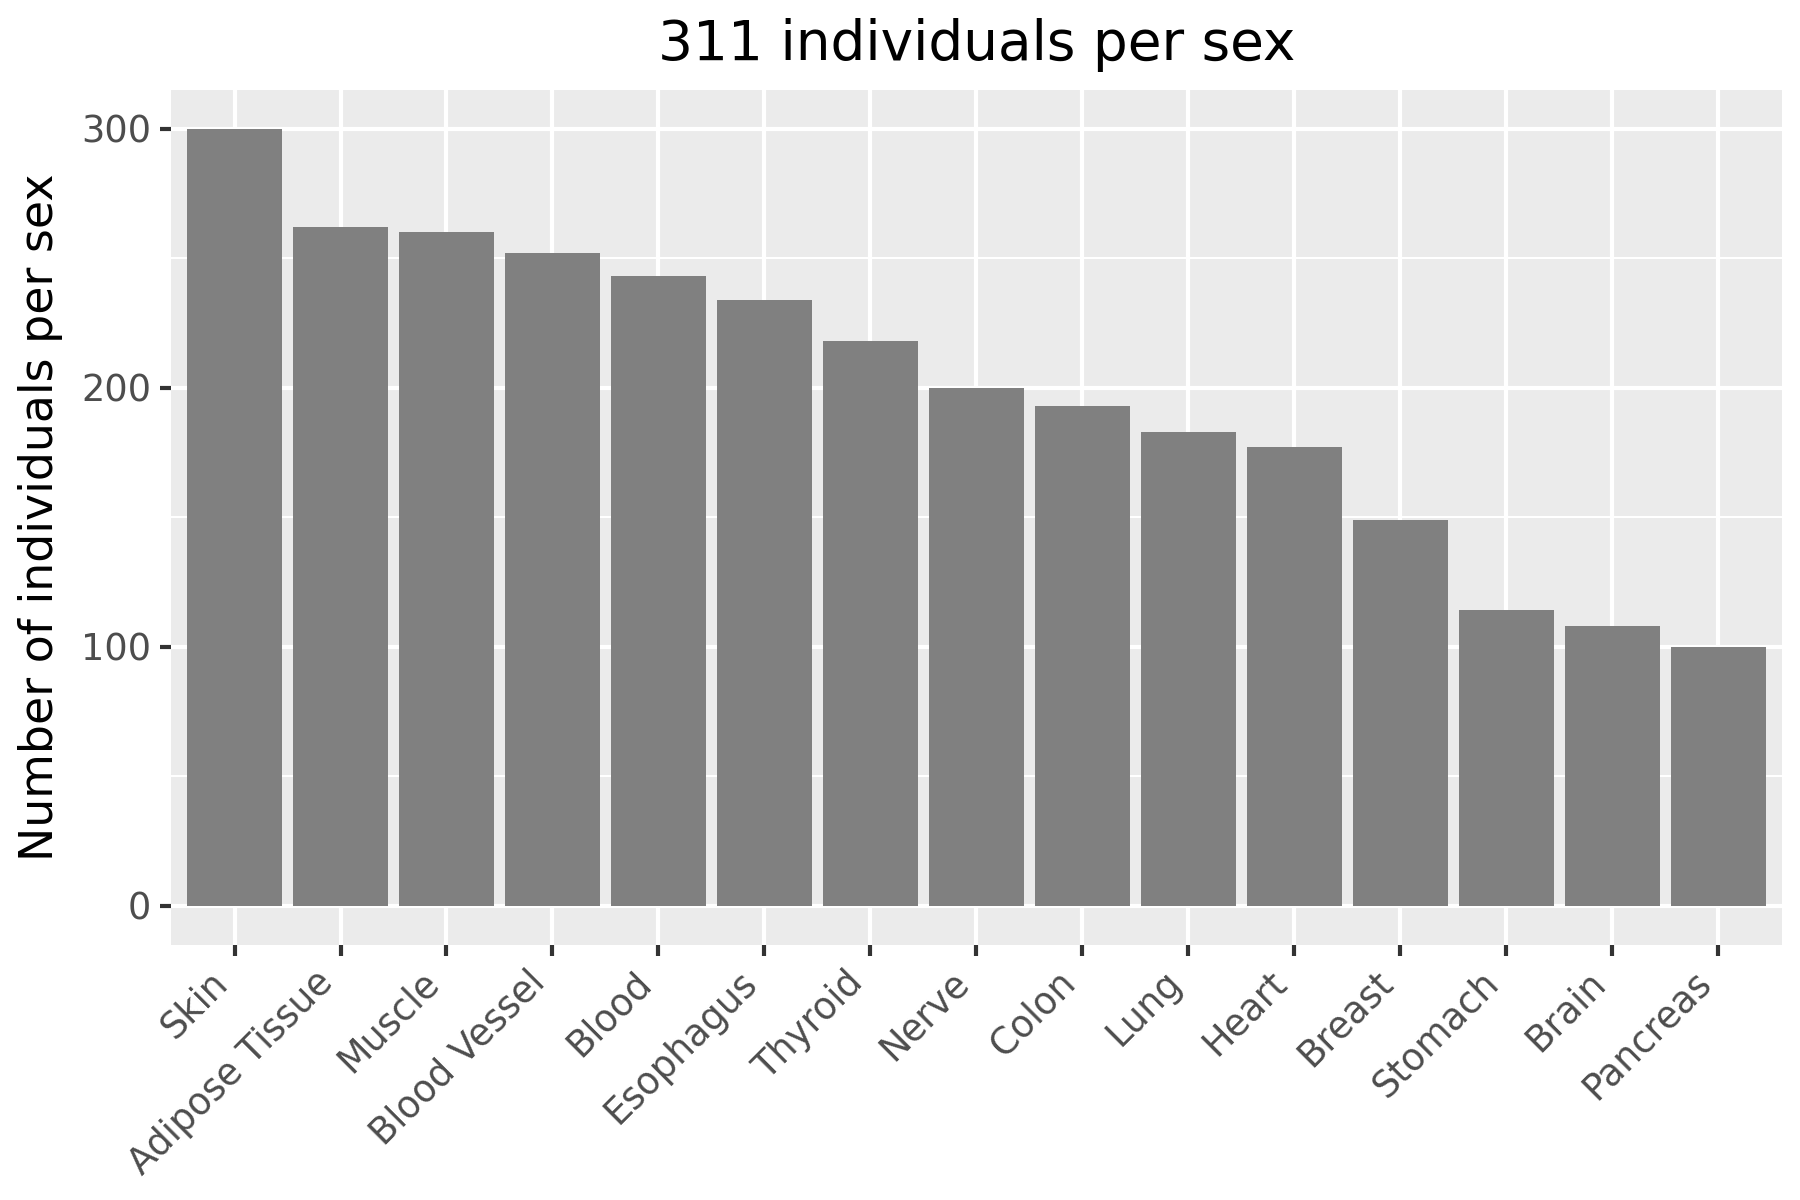

In [31]:
# Create the bar plot
p =(pn.ggplot(sample_counts_per_tissue_sex, pn.aes(x='tissue', y='Male')) +
        pn.geom_bar(stat='identity', fill='gray') + 
        pn.theme(
            figure_size=(6, 4),
            axis_text_x=pn.element_text(angle=45, hjust=1),
            dpi=150
        ) +
        pn.labs(y='Number of individuals per sex', x='', title='311 individuals per sex'))
p

In [32]:
p.save("/data/nasif12/home_if12/tsi/projects/kipoi_veff_analysis/plots/sex_test_tissues.png", width=6, height=4, dpi=300)

/opt/modules/i12g/anaconda/envs/kipoi-veff-analysis/lib/python3.12/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 6 x 4 in image.
/opt/modules/i12g/anaconda/envs/kipoi-veff-analysis/lib/python3.12/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: /data/nasif12/home_if12/tsi/projects/kipoi_veff_analysis/plots/sex_test_tissues.png


In [33]:
final_xrds

<xarray.Dataset> Size: 647kB
Dimensions:     (sample: 5986, transcript: 4)
Coordinates:
  * sample      (sample) object 48kB 'GTEX-132QS-0826-SM-5K7WV' ... 'GTEX-1H1...
  * transcript  (transcript) object 32B 'ENST00000160262' ... 'ENST00000592945'
    subtissue   (sample) object 48kB 'Adipose - Visceral (Omentum)' ... 'Thyr...
    tissue      (sample) object 48kB 'Adipose Tissue' ... 'Thyroid'
    individual  (sample) <U10 239kB 'GTEX-132QS' 'GTEX-1EN7A' ... 'GTEX-1H1CY'
    sex         (sample) object 48kB 'Male' 'Male' 'Male' ... 'Female' 'Female'
    gene        (transcript) object 32B 'ENSG00000076662' ... 'ENSG00000076662'
    chrom       (transcript) object 32B 'chr19' 'chr19' 'chr19' 'chr19'
Data variables:
    tpm         (transcript, sample) float32 96kB 7.92 3.82 4.65 ... 4.26 1.35
    total_tpm   (sample) float32 24kB 22.19 8.57 9.06 12.05 ... 7.62 8.63 5.14
    proportion  (transcript, sample) float32 96kB 0.3569 0.4457 ... 0.2626

## Analysis

In [42]:
def run_dirichlet_reg(df):
    print('data pivot')
    df = df.pivot(index=['sample', 'tissue', 'individual', 'sex'], columns='transcript', values='proportion')
    prop_columns = [f'proportion_{c}' for c in df.columns]
    df.columns = prop_columns
    df = df.reset_index()
    with (ro.default_converter + pandas2ri.converter).context():
        ro.r.assign('df', df)
        ro.r.assign('propColumns', ro.StrVector(prop_columns))

    
    ro.r(f'''
        print('Running test')
        df$proportion = DR_data(df[, propColumns])
        print('Fitting null model')
        nullModel = DirichReg(proportion ~ tissue | tissue, data = df, model='alternative')
        print('Fitting sex model')
        sexModel = DirichReg(proportion ~ tissue + sex| tissue, data = df, model='alternative')
        print('Likelihood-ratio test')
        anovaRes = anova(nullModel, sexModel)
        print(anovaRes)
    ''')

In [43]:
# extract relevant data
df = final_xrds['proportion'].to_dataframe().reset_index()[
    ['transcript', 'sample', 'tissue', 'sex', 'proportion', 'individual']]

In [44]:
df['transcript'].unique()

array(['ENST00000160262', 'ENST00000587992', 'ENST00000592439',
       'ENST00000592945'], dtype=object)

In [37]:
df.query('(transcript == "ENST00000394179")')['tissue'].unique()

array([], dtype=object)

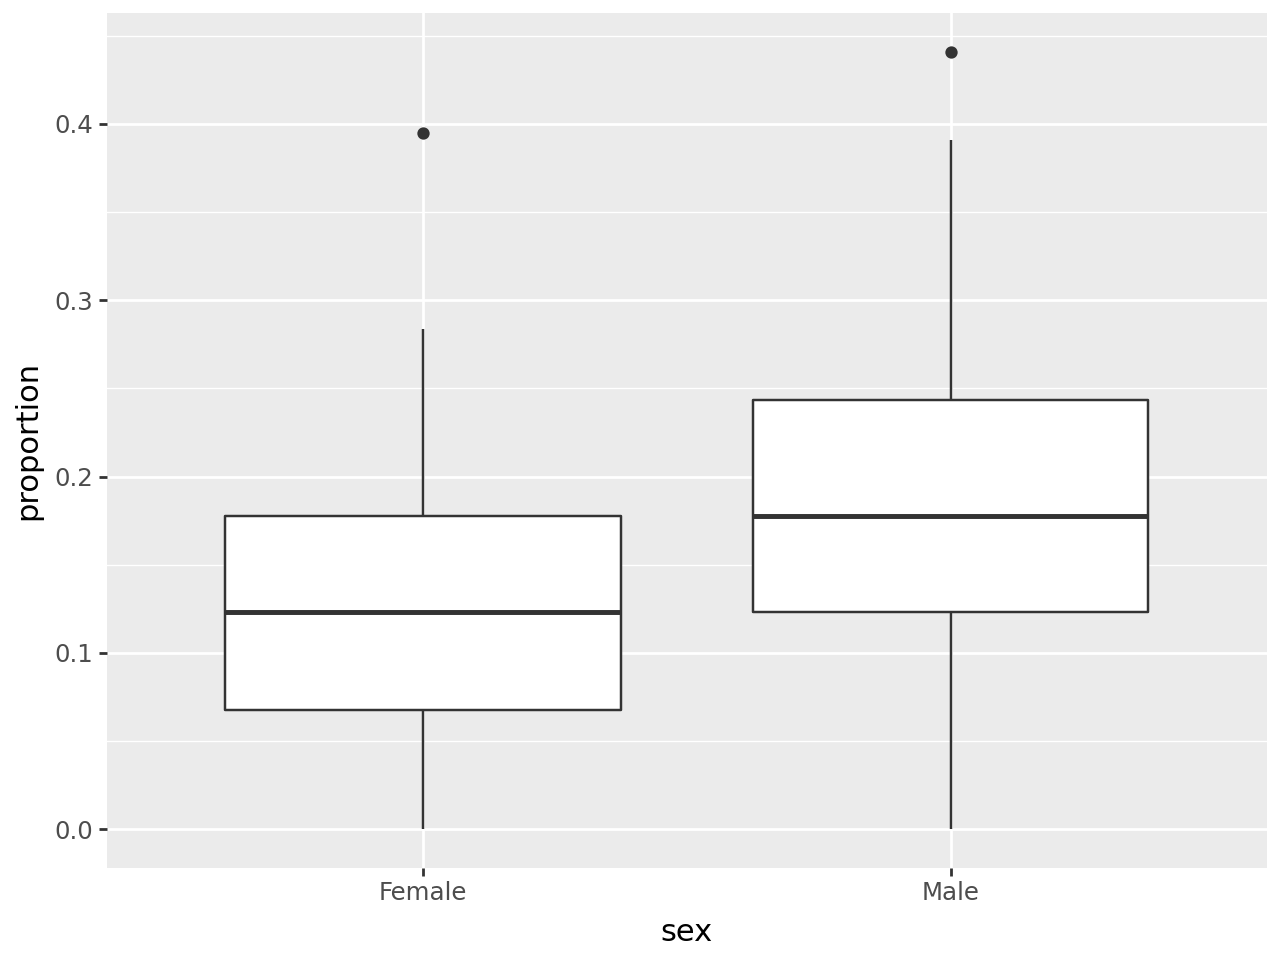

In [45]:
pn.ggplot(df.query('(transcript == "ENST00000592439") & (tissue == "Breast")'), pn.aes(y='proportion', x='sex')) + pn.geom_boxplot()

In [39]:
# extract relevant data
run_dirichlet_reg(df)

data pivot
[1] "Running test"


R[write to console]: Warning in DR_data(df[, propColumns]) :
R[write to console]: 
 
R[write to console]:  not all rows sum up to 1 => normalization forced
  some entries are 0 or 1 => transformation forced



[1] "Fitting null model"
[1] "Fitting sex model"
[1] "Likelihood-ratio test"

Analysis of Deviance Table

Model 1: DirichReg(formula = proportion ~ tissue | tissue, data = df, model =
  "alternative")
Model 2: DirichReg(formula = proportion ~ tissue | tissue, data = df, model =
  "alternative")

        Deviance N. par Difference df Pr(>Chi)
Model 1   -42244     60                       
Model 2   -42244     60          0  0        1



In [40]:
df

,transcript,sample,tissue,sex,proportion,individual
0,ENST00000160262,GTEX-132QS-0826-SM-5K7WV,Adipose Tissue,Male,0.356918,GTEX-132QS
1,ENST00000160262,GTEX-1EN7A-1626-SM-79OLV,Adipose Tissue,Male,0.445741,GTEX-1EN7A
2,ENST00000160262,GTEX-15SKB-1626-SM-6PAL6,Adipose Tissue,Male,0.513245,GTEX-15SKB
3,ENST00000160262,GTEX-1GN2E-0326-SM-COH3C,Adipose Tissue,Male,0.147718,GTEX-1GN2E
4,ENST00000160262,GTEX-1R9PM-2126-SM-E8VOB,Adipose Tissue,Male,0.531788,GTEX-1R9PM
...,...,...,...,...,...,...
23939,ENST00000592945,GTEX-1HBPM-0926-SM-ARL9C,Thyroid,Female,0.154018,GTEX-1HBPM
23940,ENST00000592945,GTEX-11ZVC-0126-SM-5986G,Thyroid,Female,0.446976,GTEX-11ZVC
23941,ENST00000592945,GTEX-1F52S-0526-SM-7P8TP,Thyroid,Female,0.408136,GTEX-1F52S
23942,ENST00000592945,GTEX-WEY5-0526-SM-3GIKZ,Thyroid,Female,0.493627,GTEX-WEY5


In [41]:
final_xrds

<xarray.Dataset> Size: 647kB
Dimensions:     (sample: 5986, transcript: 4)
Coordinates:
  * sample      (sample) object 48kB 'GTEX-132QS-0826-SM-5K7WV' ... 'GTEX-1H1...
  * transcript  (transcript) object 32B 'ENST00000160262' ... 'ENST00000592945'
    subtissue   (sample) object 48kB 'Adipose - Visceral (Omentum)' ... 'Thyr...
    tissue      (sample) object 48kB 'Adipose Tissue' ... 'Thyroid'
    individual  (sample) <U10 239kB 'GTEX-132QS' 'GTEX-1EN7A' ... 'GTEX-1H1CY'
    sex         (sample) object 48kB 'Male' 'Male' 'Male' ... 'Female' 'Female'
    gene        (transcript) object 32B 'ENSG00000076662' ... 'ENSG00000076662'
    chrom       (transcript) object 32B 'chr19' 'chr19' 'chr19' 'chr19'
Data variables:
    tpm         (transcript, sample) float32 96kB 7.92 3.82 4.65 ... 4.26 1.35
    total_tpm   (sample) float32 24kB 22.19 8.57 9.06 12.05 ... 7.62 8.63 5.14
    proportion  (transcript, sample) float32 96kB 0.3569 0.4457 ... 0.2626

In [ ]:
final_xrds['proportion'].to_dataframe().reset_index()[
    ['transcript', 'sample', 'tissue', 'sex', 'proportion', 'individual']]

In [32]:
df

,transcript,sample,tissue,sex,proportion,individual
0,ENST00000319580,GTEX-132QS-0826-SM-5K7WV,Adipose Tissue,Male,0.375912,GTEX-132QS
1,ENST00000319580,GTEX-1EN7A-1626-SM-79OLV,Adipose Tissue,Male,0.200260,GTEX-1EN7A
2,ENST00000319580,GTEX-15SKB-1626-SM-6PAL6,Adipose Tissue,Male,0.311392,GTEX-15SKB
3,ENST00000319580,GTEX-1GN2E-0326-SM-COH3C,Adipose Tissue,Male,0.333969,GTEX-1GN2E
4,ENST00000319580,GTEX-1R9PM-2126-SM-E8VOB,Adipose Tissue,Male,0.148649,GTEX-1R9PM
...,...,...,...,...,...,...
13399,ENST00000620154,GTEX-1HBPM-0926-SM-ARL9C,Thyroid,Female,0.604651,GTEX-1HBPM
13400,ENST00000620154,GTEX-11ZVC-0126-SM-5986G,Thyroid,Female,0.669031,GTEX-11ZVC
13401,ENST00000620154,GTEX-1F52S-0526-SM-7P8TP,Thyroid,Female,0.865462,GTEX-1F52S
13402,ENST00000620154,GTEX-WEY5-0526-SM-3GIKZ,Thyroid,Female,0.840860,GTEX-WEY5


In [124]:
# extract relevant data
# random_individuals_df = df[['individual', 'sex']].drop_duplicates().reset_index(drop=True)
# random_individuals_df['sex'] = np.random.permutation(random_individuals_df['sex'].values)
# random_individuals_df = random_individuals_df.set_index('individual')
random_df = df.copy()
# random_df['sex'] = random_individuals_df.loc[random_df['individual'].values]['sex'].values
random_df['sex'] = np.random.permutation(random_df['sex'].values)
run_dirichlet_reg(random_df)

data pivot
[1] "Running test"


R[write to console]: Warning in DR_data(df[, propColumns]) :
R[write to console]: 
 
R[write to console]:  not all rows sum up to 1 => normalization forced
  some entries are 0 or 1 => transformation forced



[1] "Fitting null model"
[1] "Fitting sex model"
[1] "Likelihood-ratio test"

Analysis of Deviance Table

Model 1: DirichReg(formula = proportion ~ tissue | tissue, data = df, model =
  "alternative")
Model 2: DirichReg(formula = proportion ~ tissue | tissue, data = df, model =
  "alternative")

        Deviance N. par Difference df Pr(>Chi)
Model 1  -4298.7     60                       
Model 2  -4298.7     60          0  0        1



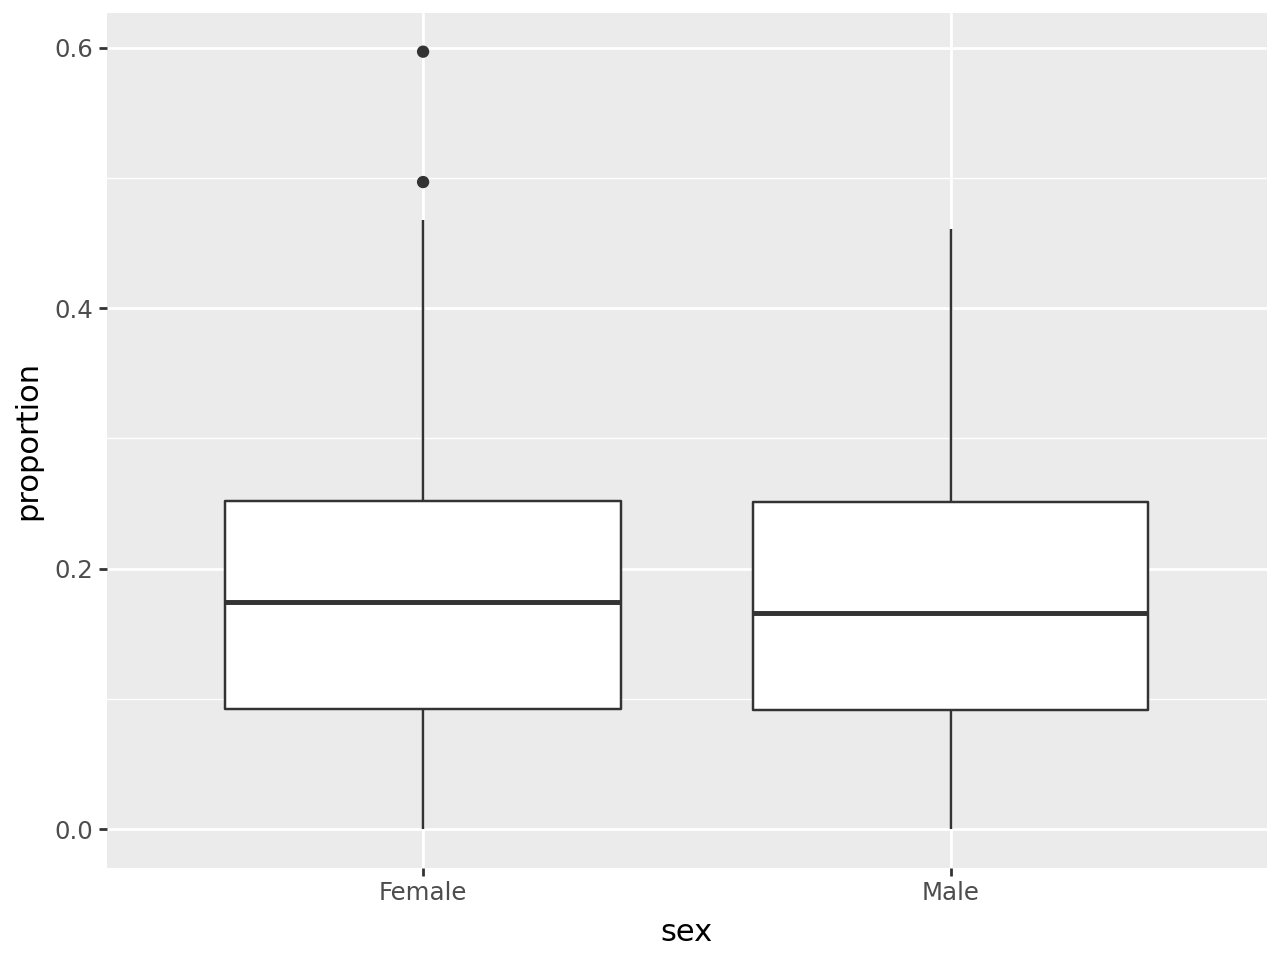

In [125]:
pn.ggplot(random_df.query('(transcript == "ENST00000394179") & (tissue == "Esophagus")'), pn.aes(y='proportion', x='sex')) + pn.geom_boxplot()

In [84]:
ro.r('print(coef(sexModel))')

$beta
$beta$proportion_ENST00000369066
NULL

$beta$proportion_ENST00000633556
          (Intercept)   tissueAdrenal Gland           tissueBlood 
         3.694478e-01          2.334150e+00          1.920182e+00 
   tissueBlood Vessel           tissueBrain          tissueBreast 
        -6.695918e-01          2.025032e+00          4.804763e-01 
          tissueColon       tissueEsophagus           tissueHeart 
         2.031292e-01          7.502418e-01          1.570430e+00 
          tissueLiver            tissueLung          tissueMuscle 
         2.834996e+00         -3.222155e-01          1.095047e+00 
          tissueNerve        tissuePancreas       tissuePituitary 
        -6.815626e-01          9.133785e+00          2.309212e+00 
           tissueSkin tissueSmall Intestine          tissueSpleen 
        -6.236908e-01          4.870358e-01          1.307726e+00 
        tissueStomach         tissueThyroid               sexMale 
         1.981662e+00          2.076358e-01        

beta,[19]
gamma,[19]


In [108]:
ro.r('print(summary(sexModel))')


Call:
DirichReg(formula = proportion ~ tissue * sex | tissue, data = df, model =
"alternative")

Standardized Residuals:
                                Min       1Q   Median      3Q     Max
proportion_ENST00000360317  -1.7375  -0.5303   0.1724  0.8483  5.1906
proportion_ENST00000394179  -1.6385  -0.4365   0.2513  0.8922  4.0908
proportion_ENST00000477054  -2.1349  -0.6022  -0.2864  0.0634  2.2187
proportion_ENST00000479136  -2.1248  -0.5889  -0.2037  0.2334  2.3765

MEAN MODELS:
------------------------------------------------------------------
Coefficients for variable no. 1: proportion_ENST00000360317
- variable omitted (reference category) -
------------------------------------------------------------------
Coefficients for variable no. 2: proportion_ENST00000394179
                           Estimate Std. Error z value Pr(>|z|)    
(Intercept)                -0.38667    0.06481  -5.966 2.43e-09 ***
tissueBlood                 0.81821    0.09208   8.886  < 2e-16 ***
tissueBlood Ve

<rpy2.rinterface_lib.sexp.NULLType object at 0x7ff498854a90> [0]